# **Bitcoin price prediction - Final scores**
### Big Data Computing final project - A.Y. 2022 - 2023
Prof. Gabriele Tolomei

MSc in Computer Science

La Sapienza, University of Rome

### Author: Corsi Danilo (1742375) - corsi.1742375@studenti.uniroma1.it


---


Description: display of final scores and making predictions on the test set with the models trained on the whole train / validation set.

# Global constants, dependencies, libraries and tools

In [1]:
# Main constants
LOCAL_RUNNING = False
SLOW_OPERATIONS = True # Decide whether or not to use operations that might slow down notebook execution
ROOT_DIR = "D:/Documents/Repository/BDC/project" if LOCAL_RUNNING else "/content/drive"

In [2]:
if not LOCAL_RUNNING:
    # Point Colaboratory to Google Drive
    from google.colab import drive

    # Define GDrive paths
    drive.mount(ROOT_DIR, force_remount=True)

    # Install Spark and related dependencies
    !pip install pyspark
    !pip install -U -q PyDrive -qq
    !apt install openjdk-8-jdk-headless -qq

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=9b349130b0882f79fe95852ed28dc61824078eda5bcdb2cb46ecee03180fed52
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting prev

## Import my utilities

In [29]:
# Set main dir
MAIN_DIR = ROOT_DIR + "" if LOCAL_RUNNING else ROOT_DIR + "/MyDrive/BDC/project"

# Utilities dir
UTILITIES_DIR = MAIN_DIR + "/utilities"

# Import my utilities
import sys
sys.path.append(UTILITIES_DIR)

from imports import *
import utilities

In [4]:
# Set main dir
MAIN_DIR = ROOT_DIR + "" if LOCAL_RUNNING else ROOT_DIR + "/MyDrive/BDC/project"

###################
# --- DATASET --- #
###################

# Datasets dirs
DATASET_OUTPUT_DIR = MAIN_DIR + "/datasets/output"

# Datasets names
DATASET_TEST_NAME = "bitcoin_blockchain_data_15min_test"

# Datasets paths
DATASET_TEST = DATASET_OUTPUT_DIR + "/" + DATASET_TEST_NAME + ".parquet"

####################
# --- FEATURES --- #
####################

# Features dir
FEATURES_DIR = MAIN_DIR + "/features"

# Features labels
FEATURES_LABEL = "features"
TARGET_LABEL = "next-market-price"

# Features names
FEATURES_CORRELATION_LABEL = "features_correlation"
BASE_FEATURES_LABEL = "base_features"
BASE_AND_MOST_CORR_FEATURES_LABEL = "base_and_most_corr_features"
BASE_AND_LEAST_CORR_FEATURES_LABEL = "base_and_least_corr_features"

# Features paths
FEATURES_CORRELATION = FEATURES_DIR + "/" + FEATURES_CORRELATION_LABEL + ".json"
BASE_FEATURES = FEATURES_DIR + "/" + BASE_FEATURES_LABEL + ".json"
BASE_AND_MOST_CORR_FEATURES = FEATURES_DIR + "/" + BASE_AND_MOST_CORR_FEATURES_LABEL + ".json"
BASE_AND_LEAST_CORR_FEATURES = FEATURES_DIR + "/" + BASE_AND_LEAST_CORR_FEATURES_LABEL + ".json"

##################
# --- MODELS --- #
##################

# Model names
LR_MODEL_NAME = "LinearRegression"
GLR_MODEL_NAME = "GeneralizedLinearRegression"
RF_MODEL_NAME = "RandomForestRegressor"
GBT_MODEL_NAME = "GradientBoostingTreeRegressor"

# Model dir
MODELS_DIR = MAIN_DIR + "/models"

# Model path
LR_MODEL = MODELS_DIR + "/" + LR_MODEL_NAME
GLR_MODEL = MODELS_DIR + "/" + GLR_MODEL_NAME
RF_MODEL = MODELS_DIR + "/" + RF_MODEL_NAME
GBT_MODEL = MODELS_DIR + "/" + GBT_MODEL_NAME

###################
# --- RESULTS --- #
###################

# splits names
BLOCK_SPLITS_NAME = "block_splits"
WALK_FORWARD_SPLITS_NAME = "walk_forward_splits"
SHORT_TERM_SPLITS_NAME = "single_split"

# Results dir
RESULTS_DIR = MAIN_DIR + "/results"
RESULTS_FINAL_DIR = RESULTS_DIR + "/final"

In [5]:
# Suppression of warnings for better reading
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

if LOCAL_RUNNING: pio.renderers.default='notebook' # To correctly export the notebook in html format

# Create the pyspark session

In [6]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '12G').\
                set('spark.driver.memory', '12G').\
                set('spark.driver.maxResultSize', '109G').\
                set("spark.kryoserializer.buffer.max", "1G").\
                setAppName("BitcoinPricePrediction").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Loading dataset

In [7]:
# Load datasets into pyspark dataset objects
df = spark.read.load(DATASET_TEST,
                         format="parquet",
                         sep=",",
                         inferSchema="true",
                         header="true"
                    )

In [8]:
def dataset_info(dataset):
  # Print dataset
  dataset.show(20)

  # Get the number of rows
  num_rows = dataset.count()

  # Get the number of columns
  num_columns = len(dataset.columns)

  # Print the shape of the dataset
  print("Shape:", (num_rows, num_columns))

  # Print the schema of the dataset
  dataset.printSchema()

In [9]:
dataset_info(df)

+-------------------+------+------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------------+--------------------+------------------+--------------------+--------------------+------------------+-----------------+--------------------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|          timestamp|    id|market-price|     opening-price|     highest-price|      lowest-price|     closing-price|  trade-volume-btc|      total-bitcoins|          market-cap|    trade-volume-usd|       blocks-size|    avg-block-size|n-transactions-total|n-transactions-per-block|           hash-rate|        difficulty|      miners-revenue|transaction-fees-usd|n-unique-addresses|   n-transactions|estimated-transaction-volume-u

# Load train / validation data

In [10]:
# Load models results
splits_list = [BLOCK_SPLITS_NAME, WALK_FORWARD_SPLITS_NAME, SHORT_TERM_SPLITS_NAME]
models_list = [LR_MODEL_NAME, GLR_MODEL_NAME, RF_MODEL_NAME, GBT_MODEL_NAME]
train_valid_results = pd.DataFrame(columns=['Model', 'Type', 'Dataset', 'Splitting', 'Features', 'Parameters', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Adjusted_R2', 'Time'])
train_valid_accuracy = pd.DataFrame(columns=['Model', 'Features', 'Splitting', 'Accuracy (default)', 'Accuracy (tuned)'])
for split in splits_list:
    for model in models_list:
        if split == BLOCK_SPLITS_NAME:
            train_valid_results = pd.concat([train_valid_results, pd.read_csv(RESULTS_DIR + "/" + split + "/" + model + "_rel.csv")], ignore_index=True)
            train_valid_accuracy = pd.concat([train_valid_accuracy, pd.read_csv(RESULTS_DIR + "/" + split + "/" + model + "_accuracy.csv")], ignore_index=True)
        elif split == WALK_FORWARD_SPLITS_NAME:
            train_valid_results = pd.concat([train_valid_results, pd.read_csv(RESULTS_DIR + "/" + split + "/" + model + "_rel.csv")], ignore_index=True)
            train_valid_accuracy = pd.concat([train_valid_accuracy, pd.read_csv(RESULTS_DIR + "/" + split + "/" + model + "_accuracy.csv")], ignore_index=True)
        elif split == SHORT_TERM_SPLITS_NAME:
            train_valid_results = pd.concat([train_valid_results, pd.read_csv(RESULTS_DIR + "/" + split + "/" + model + "_rel.csv")], ignore_index=True)
            train_valid_accuracy = pd.concat([train_valid_accuracy, pd.read_csv(RESULTS_DIR + "/" + split + "/" + model + "_accuracy.csv")], ignore_index=True)

In [11]:
train_valid_results

,Model,Type,Dataset,Splitting,Features,Parameters,RMSE,MSE,MAE,MAPE,R2,Adjusted_R2,Time
0,LinearRegression,default_norm,valid,block_splits,base_and_least_corr_features_norm,"[100, 0.0, 0.0]",2227.412278,8.171259e+06,1870.345923,0.052480,-1.631054,-1.633063,0.461474
1,LinearRegression,cross_val,valid,block_splits,base_and_least_corr_features_norm,"[5, 0.8, 0.0]",1032.704613,1.732495e+06,776.557626,0.022809,0.583006,0.582688,0.301061
2,GeneralizedLinearRegression,default_norm,valid,block_splits,base_and_least_corr_features_norm,"[25, 0]",2227.412278,8.171259e+06,1870.345923,0.052480,-1.631054,-1.633063,0.363326
3,GeneralizedLinearRegression,cross_val,valid,block_splits,base_and_least_corr_features_norm,"[5, 0.1, 'gaussian', 'log']",1613.055150,4.358777e+06,1318.116337,0.036782,0.253175,0.252605,0.241773
4,RandomForestRegressor,default,valid,block_splits,base_features,"[20, 5, 42]",874.913453,8.768811e+05,579.679197,0.022112,0.337898,0.337393,1.108412
5,RandomForestRegressor,cross_val,valid,block_splits,base_features,"[30, 10, 42]",772.597736,7.135922e+05,497.460229,0.018699,0.530111,0.529753,2.466774
6,GradientBoostingTreeRegressor,default,valid,block_splits,base_features,"[20, 5, 0.1, 42]",694.841380,6.411613e+05,446.415138,0.016936,0.763292,0.763111,5.696860
7,GradientBoostingTreeRegressor,cross_val,valid,block_splits,base_features,"[3, 5, 0.1, 42]",732.282155,7.287943e+05,478.257071,0.018009,0.735400,0.735198,1.069041
8,LinearRegression,default_norm,valid,walk_forward_splits,base_and_least_corr_features_norm,"[100, 0.0, 0.0]",1743.625346,5.340021e+06,1496.804362,0.043785,0.360428,0.359915,0.394546
9,LinearRegression,cross_val,valid,walk_forward_splits,base_features_norm,"[5, 0.0, 0.0]",1664.415862,4.874436e+06,1430.474180,0.041731,0.435987,0.435535,0.317339


In [12]:
train_valid_accuracy

,Model,Features,Splitting,Accuracy (default),Accuracy (tuned)
0,LinearRegression,base_and_least_corr_features_norm,block_splits,48.211971,46.164697
1,GeneralizedLinearRegression,base_and_least_corr_features_norm,block_splits,48.211971,48.215783
2,RandomForestRegressor,base_features,block_splits,53.808616,54.292795
3,GradientBoostingTreeRegressor,base_features,block_splits,51.044605,50.171559
4,LinearRegression,base_features_norm,walk_forward_splits,48.015455,50.306364
5,GeneralizedLinearRegression,base_features_norm,walk_forward_splits,48.015455,47.985455
6,RandomForestRegressor,base_features,walk_forward_splits,50.989091,51.544545
7,GradientBoostingTreeRegressor,base_features,walk_forward_splits,49.032727,50.008182
8,LinearRegression,base_and_most_corr_features_norm,single_split,46.706989,50.268817
9,GeneralizedLinearRegression,base_and_most_corr_features_norm,single_split,46.706989,46.673387


In [119]:
#Plotting parameters
colors = ['red', 'green']
legend = ["Default", "Tuned"]

# Mapping for models names
model_mapping = {
    "LinearRegression": "LR",
    "GeneralizedLinearRegression": "GLR",
    "RandomForestRegressor": "RF",
    "GradientBoostingTreeRegressor": "GBTR",
}

# Mapping for type names
type_mapping = {
    "default_norm": "Default",
    "default": "Default",
    "cross_val": "Tuned",
    "tuned": "Tuned",
}

# Mapping for splits names
splitting_mapping = {
    "block_splits": "Block splits",
    "walk_forward_splits": "Walk-forward splits",
    "single_split": "Single split"
}

features_mapping = {
    "base_features": "Base features",
    "base_and_most_corr_features_": "Base + most corr. features",
    "base_and_least_corr_features_": "Base + least corr. features",
    "base__features_norm": "Base features(norm.)",
    "base_and_most_corr_features_norm": "Base + most corr. features(norm.)",
    "base_and_least_corr_features_norm": "Base + least corr. features (norm.)"
}

In [14]:
# Make a copy of the original data
train_valid_results_copy = train_valid_results.copy()
train_valid_accuracy_copy = train_valid_accuracy.copy()

# Replace results labels
train_valid_results_copy['Model'] = train_valid_results_copy['Model'].replace(model_mapping)
train_valid_results_copy['Type'] = train_valid_results_copy['Type'].replace(type_mapping)
train_valid_results_copy['Splitting'] = train_valid_results_copy['Splitting'].replace(splitting_mapping)
train_valid_results_copy['Features'] = train_valid_results_copy['Features'].replace(features_mapping)

# Replace accuracy labels
train_valid_accuracy_copy['Model'] = train_valid_accuracy_copy['Model'].replace(model_mapping)
train_valid_accuracy_copy['Splitting'] = train_valid_accuracy_copy['Splitting'].replace(splitting_mapping)
train_valid_accuracy_copy['Features'] = train_valid_accuracy_copy['Features'].replace(features_mapping)

In [15]:
train_valid_results_copy

,Model,Type,Dataset,Splitting,Features,Parameters,RMSE,MSE,MAE,MAPE,R2,Adjusted_R2,Time
0,LR,Default,valid,Block splits,Base + least corr. features (norm.),"[100, 0.0, 0.0]",2227.412278,8.171259e+06,1870.345923,0.052480,-1.631054,-1.633063,0.461474
1,LR,Tuned,valid,Block splits,Base + least corr. features (norm.),"[5, 0.8, 0.0]",1032.704613,1.732495e+06,776.557626,0.022809,0.583006,0.582688,0.301061
2,GLR,Default,valid,Block splits,Base + least corr. features (norm.),"[25, 0]",2227.412278,8.171259e+06,1870.345923,0.052480,-1.631054,-1.633063,0.363326
3,GLR,Tuned,valid,Block splits,Base + least corr. features (norm.),"[5, 0.1, 'gaussian', 'log']",1613.055150,4.358777e+06,1318.116337,0.036782,0.253175,0.252605,0.241773
4,RF,Default,valid,Block splits,Base features,"[20, 5, 42]",874.913453,8.768811e+05,579.679197,0.022112,0.337898,0.337393,1.108412
5,RF,Tuned,valid,Block splits,Base features,"[30, 10, 42]",772.597736,7.135922e+05,497.460229,0.018699,0.530111,0.529753,2.466774
6,GBTR,Default,valid,Block splits,Base features,"[20, 5, 0.1, 42]",694.841380,6.411613e+05,446.415138,0.016936,0.763292,0.763111,5.696860
7,GBTR,Tuned,valid,Block splits,Base features,"[3, 5, 0.1, 42]",732.282155,7.287943e+05,478.257071,0.018009,0.735400,0.735198,1.069041
8,LR,Default,valid,Walk-forward splits,Base + least corr. features (norm.),"[100, 0.0, 0.0]",1743.625346,5.340021e+06,1496.804362,0.043785,0.360428,0.359915,0.394546
9,LR,Tuned,valid,Walk-forward splits,base_features_norm,"[5, 0.0, 0.0]",1664.415862,4.874436e+06,1430.474180,0.041731,0.435987,0.435535,0.317339


In [16]:
train_valid_accuracy_copy

,Model,Features,Splitting,Accuracy (default),Accuracy (tuned)
0,LR,Base + least corr. features (norm.),Block splits,48.211971,46.164697
1,GLR,Base + least corr. features (norm.),Block splits,48.211971,48.215783
2,RF,Base features,Block splits,53.808616,54.292795
3,GBTR,Base features,Block splits,51.044605,50.171559
4,LR,base_features_norm,Walk-forward splits,48.015455,50.306364
5,GLR,base_features_norm,Walk-forward splits,48.015455,47.985455
6,RF,Base features,Walk-forward splits,50.989091,51.544545
7,GBTR,Base features,Walk-forward splits,49.032727,50.008182
8,LR,Base + most corr. features(norm.),Single split,46.706989,50.268817
9,GLR,Base + most corr. features(norm.),Single split,46.706989,46.673387


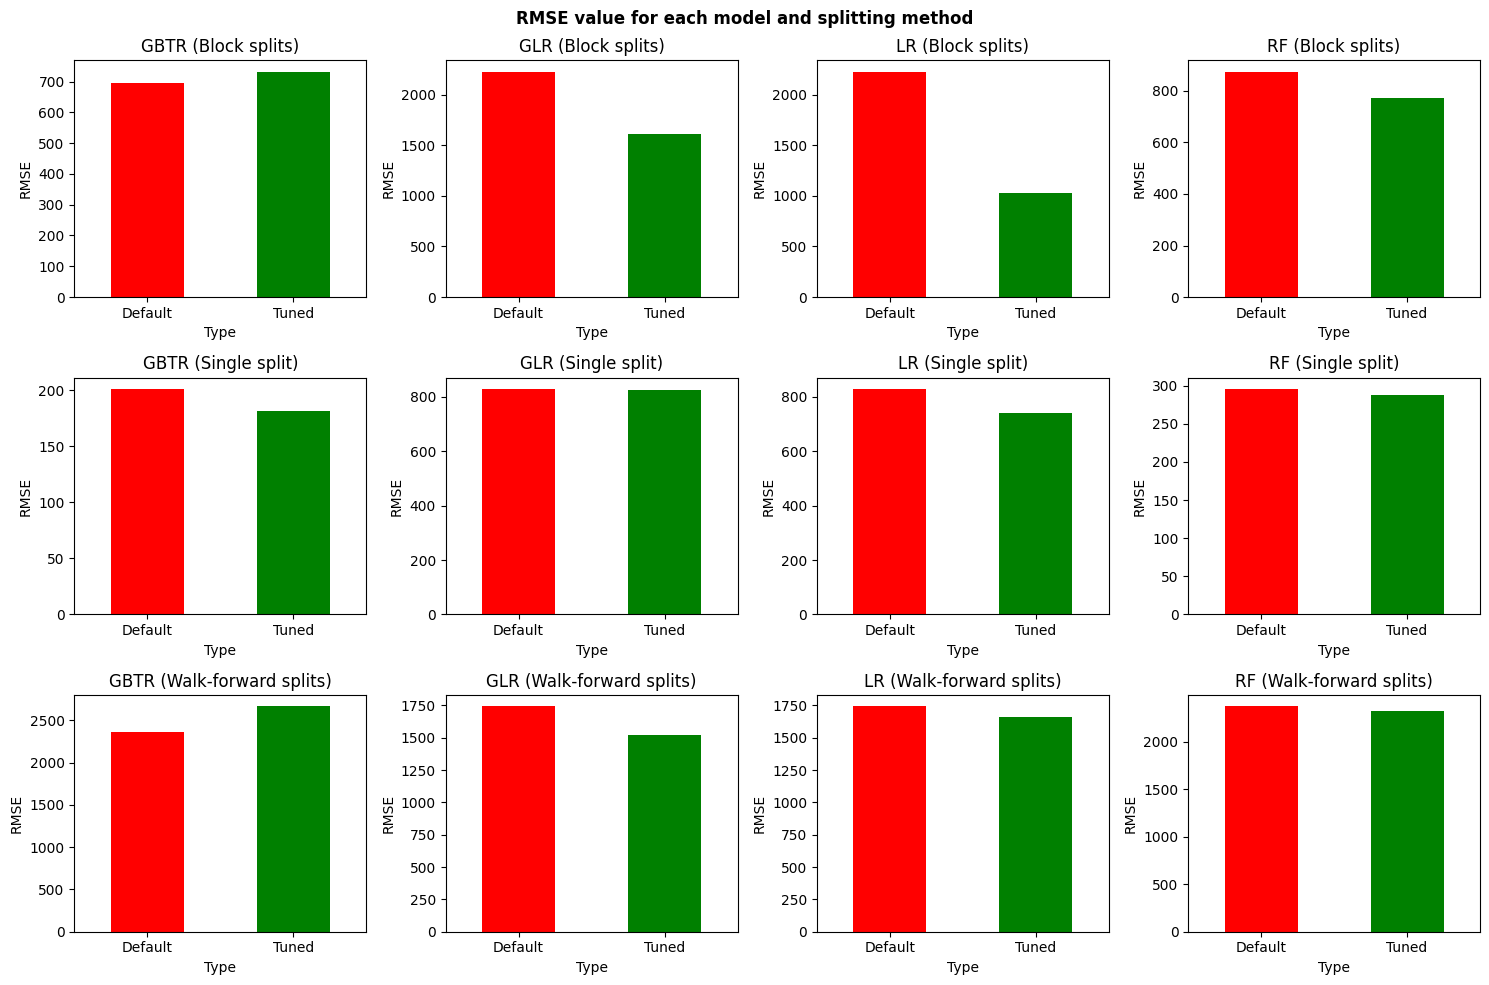

In [120]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()

grouped = train_valid_results_copy.groupby(['Splitting', 'Model'])

for ((splitting, model), group), ax in zip(grouped, axs):
    bar_plot = group.plot.bar(x='Type', y='RMSE', ax=ax, title=f'{model} ({splitting})', color=colors, legend=False)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=0)
    bar_plot.set_ylabel('RMSE')

fig.suptitle('RMSE value for each model and splitting method', weight='bold')

plt.tight_layout()
plt.show()

❗TODO

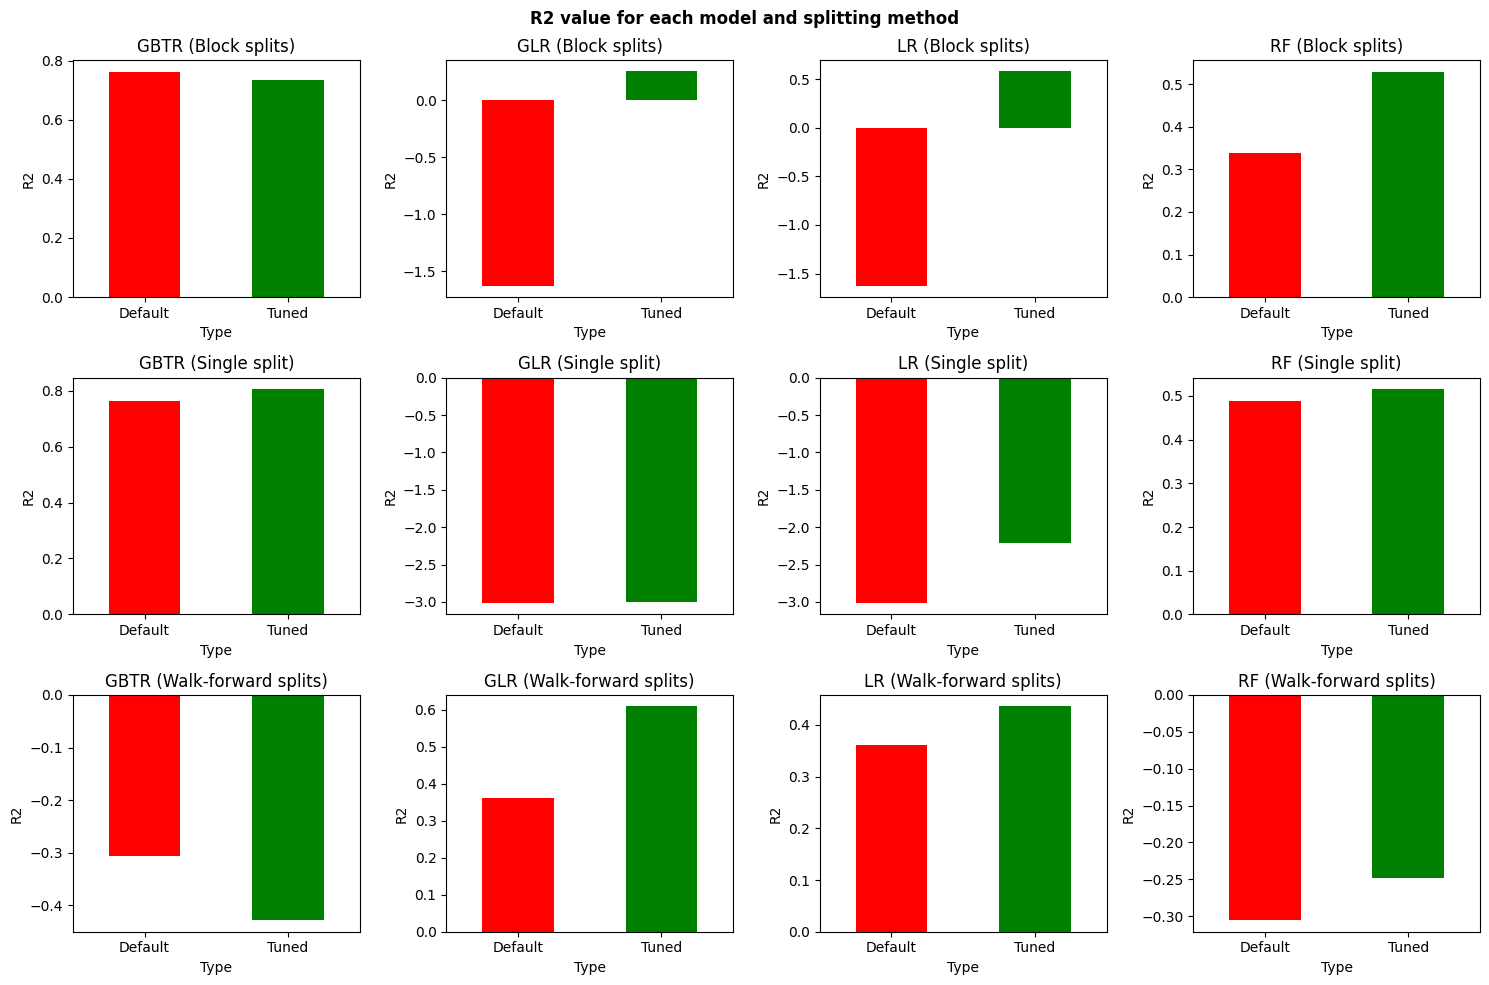

In [121]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()

grouped = train_valid_results_copy.groupby(['Splitting', 'Model'])

for ((splitting, model), group), ax in zip(grouped, axs):
    bar_plot = group.plot.bar(x='Type', y='R2', ax=ax, title=f'{model} ({splitting})', color=colors, legend=False)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=0)
    bar_plot.set_ylabel('R2')

fig.suptitle('R2 value for each model and splitting method', weight='bold')

plt.tight_layout()
plt.show()

❗TODO

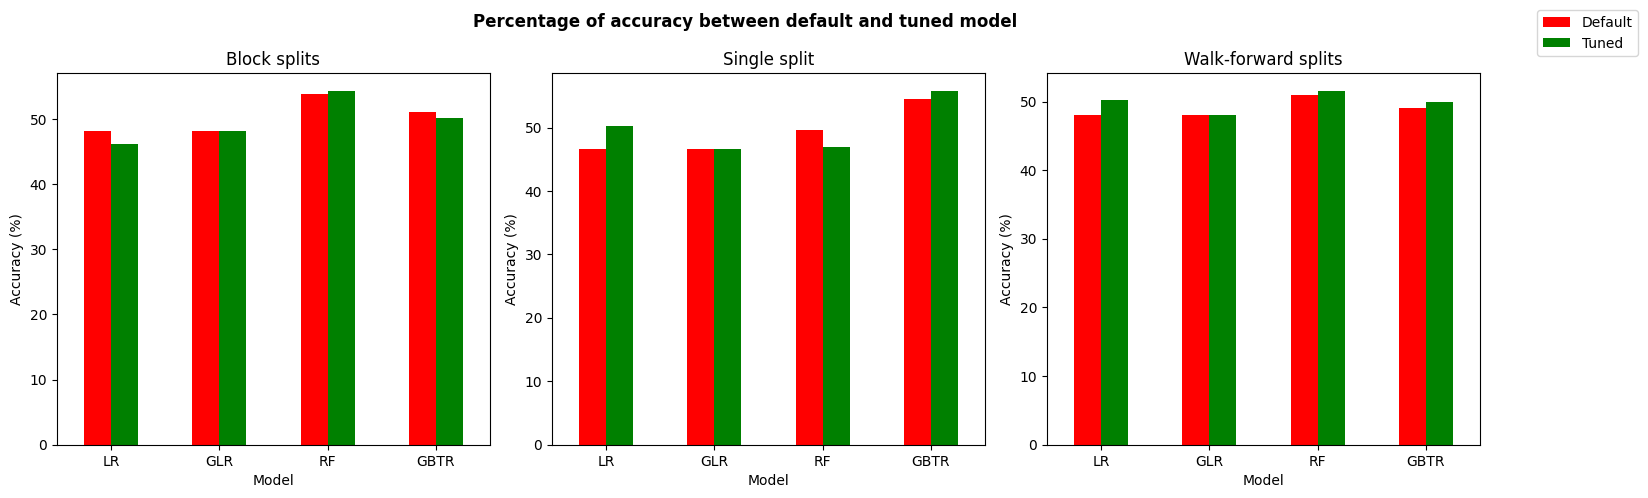

In [122]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

grouped = train_valid_accuracy_copy.groupby('Splitting')
for (name, group), ax in zip(grouped, axs):
    bar_plot = group.plot.bar(x='Model', title=name, ax=ax, legend=False, color=colors)
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=0)
    bar_plot.set_ylabel('Accuracy (%)')

fig.legend(legend, loc='upper right', bbox_to_anchor=(1.1, 1))
fig.suptitle('Percentage of accuracy between default and tuned model', weight='bold')

plt.tight_layout()
plt.yscale('linear')
plt.show()

❗TODO

# Test models
For each model, predictions on the various mini-sets are made and the obtained results are compared.

The test set is divided into further mini-sets of **1 week**, **15 days**, **1 month** and **3 months** to see how the models' performance degrades as the time taken into account increases.

❗TOFIX

In [78]:
def show_results(one_week, fifteen_days, one_month, three_months, title):
  trace1 = go.Scatter(
      x = three_months['timestamp'],
      y = three_months['market-price'].astype(float),
      mode = 'lines',
      name = 'Three months market price (usd)'
  )

  trace2 = go.Scatter(
      x = one_month['timestamp'],
      y = one_month['market-price'].astype(float),
      mode = 'lines',
      name = 'One month market price (usd)'
  )

  trace3 = go.Scatter(
      x = fifteen_days['timestamp'],
      y = fifteen_days['market-price'].astype(float),
      mode = 'lines',
      name = 'Fifteen days market price (usd)'
  )

  trace4 = go.Scatter(
      x = one_week['timestamp'],
      y = one_week['market-price'].astype(float),
      mode = 'lines',
      name = 'One week market price (usd)'
  )

  layout = dict(
      title=title + " predictions",
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  # Change the count to desired amount of months.
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1, trace2, trace3, trace4]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = title)

In [84]:
# Retrieve the last value of the timestamp column
first_timestamp = df.select(col("timestamp")).first()[0]

# Split the test set into mini-sets of 1 week, 15 days, 1 month, and 3 months
one_week_df = df.filter(col("timestamp") <= first_timestamp + relativedelta(weeks=1))
fifteen_days_df = df.filter(col("timestamp") <= first_timestamp + relativedelta(days=15))
one_month_df = df.filter(col("timestamp") <= first_timestamp + relativedelta(months=1))
three_months_df = df.filter(col("timestamp") <= first_timestamp + relativedelta(months=3))

# Save
datasets_list = [one_week_df, fifteen_days_df, one_month_df, three_months_df]

In [85]:
show_results(one_week_df.toPandas(), fifteen_days_df.toPandas(), one_month_df.toPandas(), three_months_df.toPandas(), "Test set split")

In [21]:
'''
Description: Evaluate final model by making predictions on the test set
Args:
    dataset: The dataSet which needs to be splited
    dataset_name: Name of selected dataset [one_week | fifteen_days | one_month | three_months]
    model: Trained model
    model_name: Model name selected
    features_normalization: Indicates whether features should be normalized (True) or not (False)
    features: Features to be used to make predictions
    features_name: Name of features used
    features_label: The column name of features
    target_label: The column name of target variable
Return:
    results_df: Results obtained from the evaluation
    predictions: Predictions obtained from the model
'''
def evaluate_final_model(dataset, dataset_name, model, model_name, features_normalization, features, features_name, features_label, target_label):
    # Select the type of features to be used
    dataset = utilities.select_features(dataset, features_normalization, features, features_label, target_label)

    # Make predictions
    predictions = model.transform(dataset).select(target_label, "market-price", "prediction", 'timestamp')

    # Compute validation error by several evaluators
    eval_res = utilities.model_evaluation(target_label, predictions)

    # Use dict to store each result
    results = {
        "Model": model_name,
        "Dataset": dataset_name,
        "Features": features_name,
        "RMSE": eval_res['rmse'],
        "MSE": eval_res['mse'],
        "MAE": eval_res['mae'],
        "MAPE": eval_res['mape'],
        "R2": eval_res['r2'],
        "Adjusted_R2": eval_res['adj_r2'],
    }

    # Transform dict to pandas dataset
    results_pd = pd.DataFrame(results, index=[0])

    return results_pd, predictions

In [22]:
'''
Description: How good the models are at predicting whether the price will go up or down
Args:
    dataset: The dataset which needs to be splited
Return:
    accuracy: Return the percentage of correct predictions
'''
def model_accuracy(dataset):
    # Compute the number of total rows in the DataFrame.
    total_rows = dataset.count()

    # Create a column "correct_prediction" which is worth 1 if the prediction is correct, otherwise 0
    dataset = dataset.withColumn(
        "correct_prediction",
        (
            (col("market-price") < col("next-market-price")) & (col("market-price") < col("prediction"))
        ) | (
            (col("market-price") > col("next-market-price")) & (col("market-price") > col("prediction"))
        )
    )

    # Count the number of correct predictions
    correct_predictions = dataset.filter(col("correct_prediction")).count()

    # Compite percentage of correct predictions
    accuracy = (correct_predictions / total_rows) * 100

    return accuracy

In [23]:
# Loading base features
with open(BASE_FEATURES, "r") as f:
    BASE_FEATURES = json.load(f)
print(BASE_FEATURES)

['opening-price', 'highest-price', 'lowest-price', 'closing-price', 'trade-volume-btc', 'market-price', 'market-cap', 'total-bitcoins', 'trade-volume-usd']


In [24]:
# Loading currency and additional most correlated features
with open(BASE_AND_MOST_CORR_FEATURES, "r") as f:
    BASE_AND_MOST_CORR_FEATURES = json.load(f)
print(BASE_AND_MOST_CORR_FEATURES)

['opening-price', 'highest-price', 'lowest-price', 'closing-price', 'trade-volume-btc', 'market-price', 'market-cap', 'total-bitcoins', 'trade-volume-usd', 'miners-revenue', 'sma-5-days', 'sma-7-days', 'sma-10-days', 'estimated-transaction-volume-usd', 'sma-20-days']


In [25]:
# Loading currency and additional least correlated features
with open(BASE_AND_LEAST_CORR_FEATURES, "r") as f:
    BASE_AND_LEAST_CORR_FEATURES = json.load(f)
print(BASE_AND_LEAST_CORR_FEATURES)

['opening-price', 'highest-price', 'lowest-price', 'closing-price', 'trade-volume-btc', 'market-price', 'market-cap', 'total-bitcoins', 'trade-volume-usd', 'sma-100-days', 'transaction-fees-usd', 'n-unique-addresses', 'sma-50-days', 'n-transactions-total', 'blocks-size', 'hash-rate', 'difficulty', 'avg-block-size', 'n-transactions-per-block', 'n-transactions']


In [26]:
# Load models
lr = PipelineModel.load(LR_MODEL)
glr = PipelineModel.load(GLR_MODEL)
rf = PipelineModel.load(RF_MODEL)
gbt = PipelineModel.load(GBT_MODEL)

In [30]:
# Test models
model_name_list = [LR_MODEL_NAME, GLR_MODEL_NAME, RF_MODEL_NAME, GBT_MODEL_NAME]
model_list = [lr, glr, rf, gbt]
dataset_list = [one_week_df, fifteen_days_df, one_month_df, three_months_df]
dataset_name_list = ["one_week", "fifteen_days", "one_month", "three_months"]
predictions_df = pd.DataFrame(columns=[TARGET_LABEL, "market-price", "prediction", 'timestamp'])
test_results = pd.DataFrame(columns=['Model', 'Dataset', 'Features', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'Adjusted_R2'])
test_accuracy = pd.DataFrame(columns=['Model', 'Features', 'Dataset', 'Accuracy'])

# For each model makes predictions based on the dataset type
for i, model in enumerate(model_list):
    for j, dataset in enumerate(dataset_list):
        # Select the type of feature to be used based on the model
        if (model_name_list[i] == LR_MODEL_NAME) or (model_name_list[i] == GLR_MODEL_NAME):
          FEATURES_NORMALIZATION = True
          CHOSEN_FEATURES = BASE_AND_MOST_CORR_FEATURES
          CHOSEN_FEATURES_LABEL = BASE_AND_MOST_CORR_FEATURES_LABEL
        elif model_name_list[i] == RF_MODEL_NAME:
          FEATURES_NORMALIZATION = False
          CHOSEN_FEATURES = BASE_FEATURES
          CHOSEN_FEATURES_LABEL = BASE_FEATURES_LABEL
        elif model_name_list[i] == GBT_MODEL_NAME:
          FEATURES_NORMALIZATION = False
          CHOSEN_FEATURES = BASE_AND_LEAST_CORR_FEATURES
          CHOSEN_FEATURES_LABEL = BASE_AND_LEAST_CORR_FEATURES_LABEL

        results, predictions = evaluate_final_model(dataset, dataset_name_list[j], model, model_name_list[i], FEATURES_NORMALIZATION, CHOSEN_FEATURES, CHOSEN_FEATURES_LABEL, FEATURES_LABEL, TARGET_LABEL)
        test_results = pd.concat([test_results, results], ignore_index=True)

        predictions = predictions.withColumn("Model", lit(model_name_list[i])).withColumn("Dataset", lit(dataset_name_list[j]))
        predictions_df = pd.concat([predictions_df, predictions.toPandas()], ignore_index=True)

        accuracy = model_accuracy(predictions)
        accuracy_data = {
            'Model': model_name_list[i],
            'Features': CHOSEN_FEATURES_LABEL,
            'Dataset': dataset_name_list[j],
            'Accuracy': accuracy
        }
        accuracy_data_df = pd.DataFrame(accuracy_data, index=['Model'])

        test_accuracy = pd.concat([test_accuracy, accuracy_data_df], ignore_index=True)

# Merge results and accuracy
merged_results = pd.merge(test_results, test_accuracy)
merged_results


,Model,Dataset,Features,RMSE,MSE,MAE,MAPE,R2,Adjusted_R2,Accuracy
0,LinearRegression,one_week,base_and_most_corr_features,2609.393648,6.808935e+06,2440.497200,0.088330,-2.663772,-2.685711,71.322437
1,LinearRegression,fifteen_days,base_and_most_corr_features,2946.197227,8.680078e+06,2846.512298,0.106555,-3.630695,-3.643594,66.620402
2,LinearRegression,one_month,base_and_most_corr_features,3088.128452,9.536537e+06,2995.746203,0.113862,-6.276874,-6.286668,64.494458
3,LinearRegression,three_months,base_and_most_corr_features,2282.902299,5.211643e+06,2027.938757,0.072343,0.580316,0.580126,57.835145
4,GeneralizedLinearRegression,one_week,base_and_most_corr_features,2987.628423,8.925924e+06,2804.728440,0.101492,-3.802888,-3.831648,71.322437
5,GeneralizedLinearRegression,fifteen_days,base_and_most_corr_features,3423.588091,1.172096e+07,3312.875054,0.124036,-5.252958,-5.270376,66.620402
6,GeneralizedLinearRegression,one_month,base_and_most_corr_features,3564.472652,1.270547e+07,3476.982746,0.132117,-8.694931,-8.707979,64.494458
7,GeneralizedLinearRegression,three_months,base_and_most_corr_features,2579.296794,6.652772e+06,2262.833504,0.080586,0.464265,0.464022,56.985960
8,RandomForestRegressor,one_week,base_features,513.337110,2.635150e+05,365.313231,0.013612,0.858207,0.857358,53.640416
9,RandomForestRegressor,fifteen_days,base_features,800.702651,6.411247e+05,690.581401,0.026253,0.657969,0.657017,45.038168


# Models comparison

In [89]:
def show_results(dataset, model0_name, model0_predictions, model1_name, model1_predictions, model2_name, model2_predictions, model3_name, model3_predictions, title):
  trace1 = go.Scatter(
      x = dataset['timestamp'],
      y = dataset['next-market-price'].astype(float),
      mode = 'lines',
      name = 'Actual next Market price (usd)'
  )

  trace2 = go.Scatter(
      x = model0_predictions['timestamp'],
      y = model0_predictions['prediction'].astype(float),
      mode = 'lines',
      name = model0_name + ' predictions'
  )

  trace3 = go.Scatter(
      x = model1_predictions['timestamp'],
      y = model1_predictions['prediction'].astype(float),
      mode = 'lines',
      name = model1_name + ' predictions'
  )

  trace4 = go.Scatter(
      x = model2_predictions['timestamp'],
      y = model2_predictions['prediction'].astype(float),
      mode = 'lines',
      name = model2_name + ' predictions'
  )

  trace5 = go.Scatter(
      x = model3_predictions['timestamp'],
      y = model3_predictions['prediction'].astype(float),
      mode = 'lines',
      name = model3_name + ' predictions'
  )

  layout = dict(
      title=title + " predictions",
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  # Change the count to desired amount of months.
                  dict(count=1,
                      label='1m',
                      step='month',
                      stepmode='backward'),
                  dict(count=6,
                      label='6m',
                      step='month',
                      stepmode='backward'),
                  dict(count=12,
                      label='1y',
                      step='month',
                      stepmode='backward'),
                  dict(count=36,
                      label='3y',
                      step='month',
                      stepmode='backward'),
                  dict(step='all')
              ])
          ),
          rangeslider=dict(
              visible = True
          ),
          type='date'
      )
  )

  data = [trace1, trace2, trace3, trace4, trace5]
  fig = dict(data=data, layout=layout)
  iplot(fig, filename = title)

In [91]:
# For each dataset type, it displays the predicitons of each model
for i, data in enumerate(datasets_list):
    predictions_to_show = predictions_df[predictions_df['Dataset'] == dataset_name_list[i]]

    model_0_predictions = predictions_to_show[predictions_to_show['Model'] == model_name_list[0]]
    model_1_predictions = predictions_to_show[predictions_to_show['Model'] == model_name_list[1]]
    model_2_predictions = predictions_to_show[predictions_to_show['Model'] == model_name_list[2]]
    model_3_predictions = predictions_to_show[predictions_to_show['Model'] == model_name_list[3]]

    show_results(data.toPandas(), model_name_list[0], model_0_predictions, model_name_list[1], model_1_predictions, model_name_list[2], model_2_predictions, model_name_list[3], model_3_predictions, dataset_name_list[i] + " predictions")

# Summary

In [132]:
datasets = merged_results_copy['Dataset'].unique()
models = merged_results_copy['Model'].unique()

# Manually set colors
colors = ['red', 'green', 'blue', 'orange']

# Mapping for models names
model_mapping = {
    "LinearRegression": "LR",
    "GeneralizedLinearRegression": "GLR",
    "RandomForestRegressor": "RF",
    "GradientBoostingTreeRegressor": "GBTR",
}

# Mapping for datasets names
dataset_mapping = {
    "one_week": "One week",
    "fifteen_days": "Fifteen days",
    "one_month": "One month",
    "three_months": "Three months"
}

features_mapping = {
    "base_features": "Base features",
    "base_and_most_corr_features_": "Base + most corr. features",
    "base_and_least_corr_features_": "Base + least corr. features",
    "base__features_norm": "Base features(norm.)",
    "base_and_most_corr_features_norm": "Base + most corr. features(norm.)",
    "base_and_least_corr_features_norm": "Base + least corr. features (norm.)"
}

In [133]:
# Make a copy of the original data
merged_results_copy = merged_results.copy()

# Replace results labels
merged_results_copy['Model'] = merged_results_copy['Model'].replace(model_mapping)
merged_results_copy['Dataset'] = merged_results_copy['Dataset'].replace(dataset_mapping)
merged_results_copy['Features'] = merged_results_copy['Features'].replace(features_mapping)

In [134]:
merged_results_copy

,Model,Dataset,Features,RMSE,MSE,MAE,MAPE,R2,Adjusted_R2,Accuracy
0,LR,One week,base_and_most_corr_features,2609.393648,6.808935e+06,2440.497200,0.088330,-2.663772,-2.685711,71.322437
1,LR,Fifteen days,base_and_most_corr_features,2946.197227,8.680078e+06,2846.512298,0.106555,-3.630695,-3.643594,66.620402
2,LR,One month,base_and_most_corr_features,3088.128452,9.536537e+06,2995.746203,0.113862,-6.276874,-6.286668,64.494458
3,LR,Three months,base_and_most_corr_features,2282.902299,5.211643e+06,2027.938757,0.072343,0.580316,0.580126,57.835145
4,GLR,One week,base_and_most_corr_features,2987.628423,8.925924e+06,2804.728440,0.101492,-3.802888,-3.831648,71.322437
5,GLR,Fifteen days,base_and_most_corr_features,3423.588091,1.172096e+07,3312.875054,0.124036,-5.252958,-5.270376,66.620402
6,GLR,One month,base_and_most_corr_features,3564.472652,1.270547e+07,3476.982746,0.132117,-8.694931,-8.707979,64.494458
7,GLR,Three months,base_and_most_corr_features,2579.296794,6.652772e+06,2262.833504,0.080586,0.464265,0.464022,56.985960
8,RF,One week,Base features,513.337110,2.635150e+05,365.313231,0.013612,0.858207,0.857358,53.640416
9,RF,Fifteen days,Base features,800.702651,6.411247e+05,690.581401,0.026253,0.657969,0.657017,45.038168


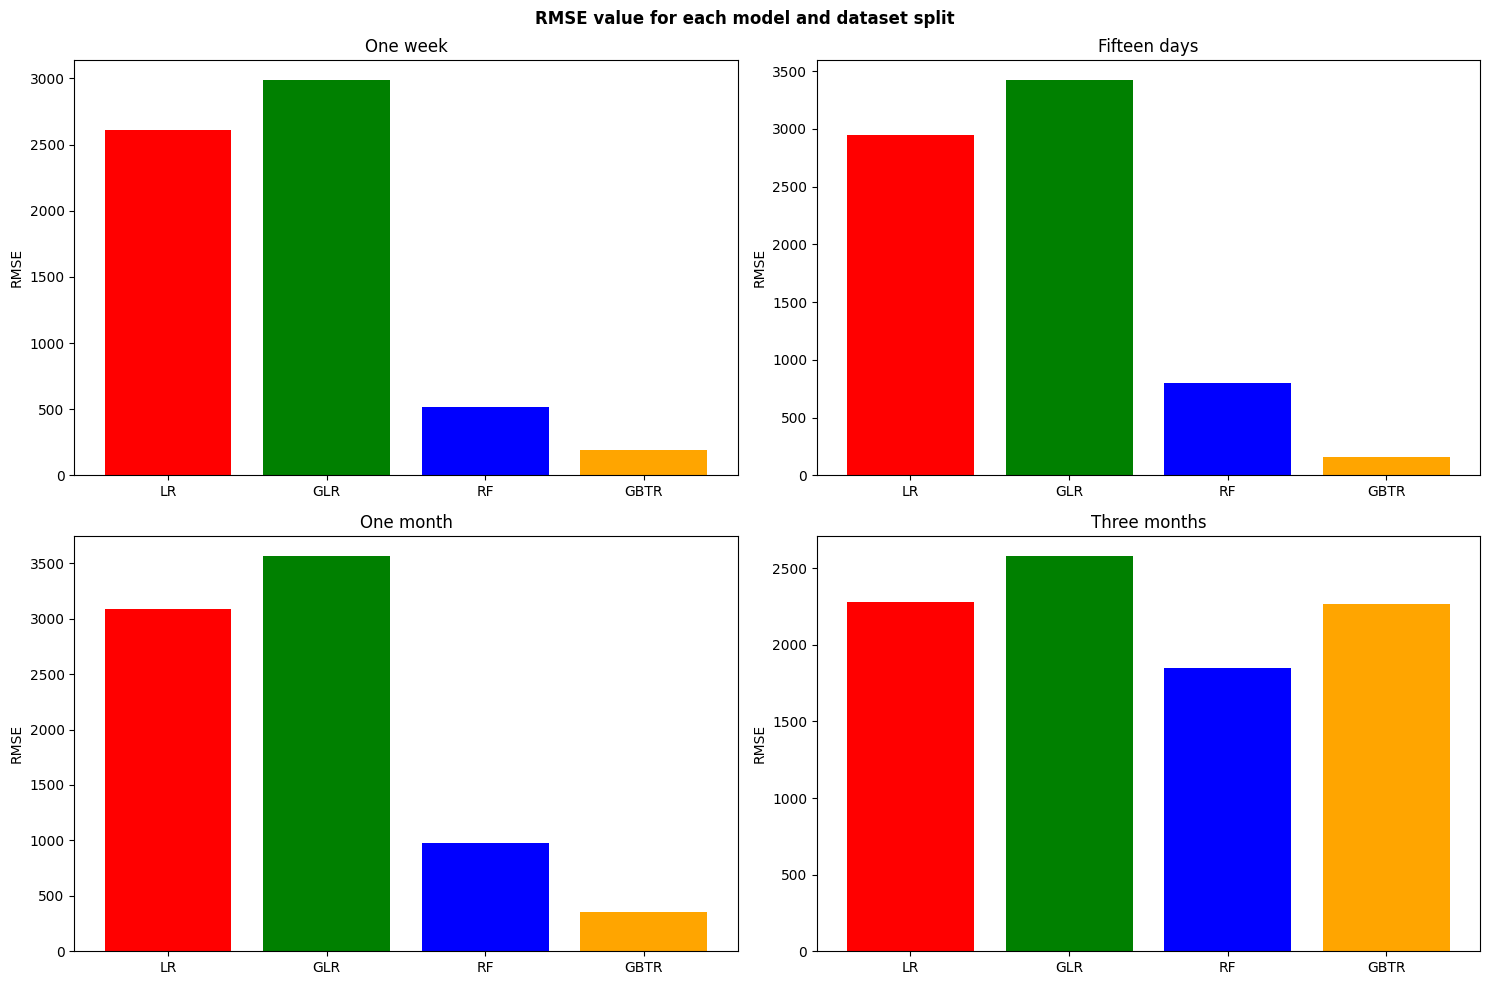

In [135]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, dataset in enumerate(datasets):
    ax = axs[i]
    data = merged_results_copy[merged_results_copy['Dataset'] == dataset]
    for j, model in enumerate(models):
        model_data = data[data['Model'] == model]
        ax.bar(j, model_data['RMSE'].values[0], color=colors[j])
    ax.set_title(dataset)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=0)
    ax.set_ylabel('RMSE')

fig.suptitle('RMSE value for each model and dataset split', weight='bold')
plt.tight_layout()
plt.show()

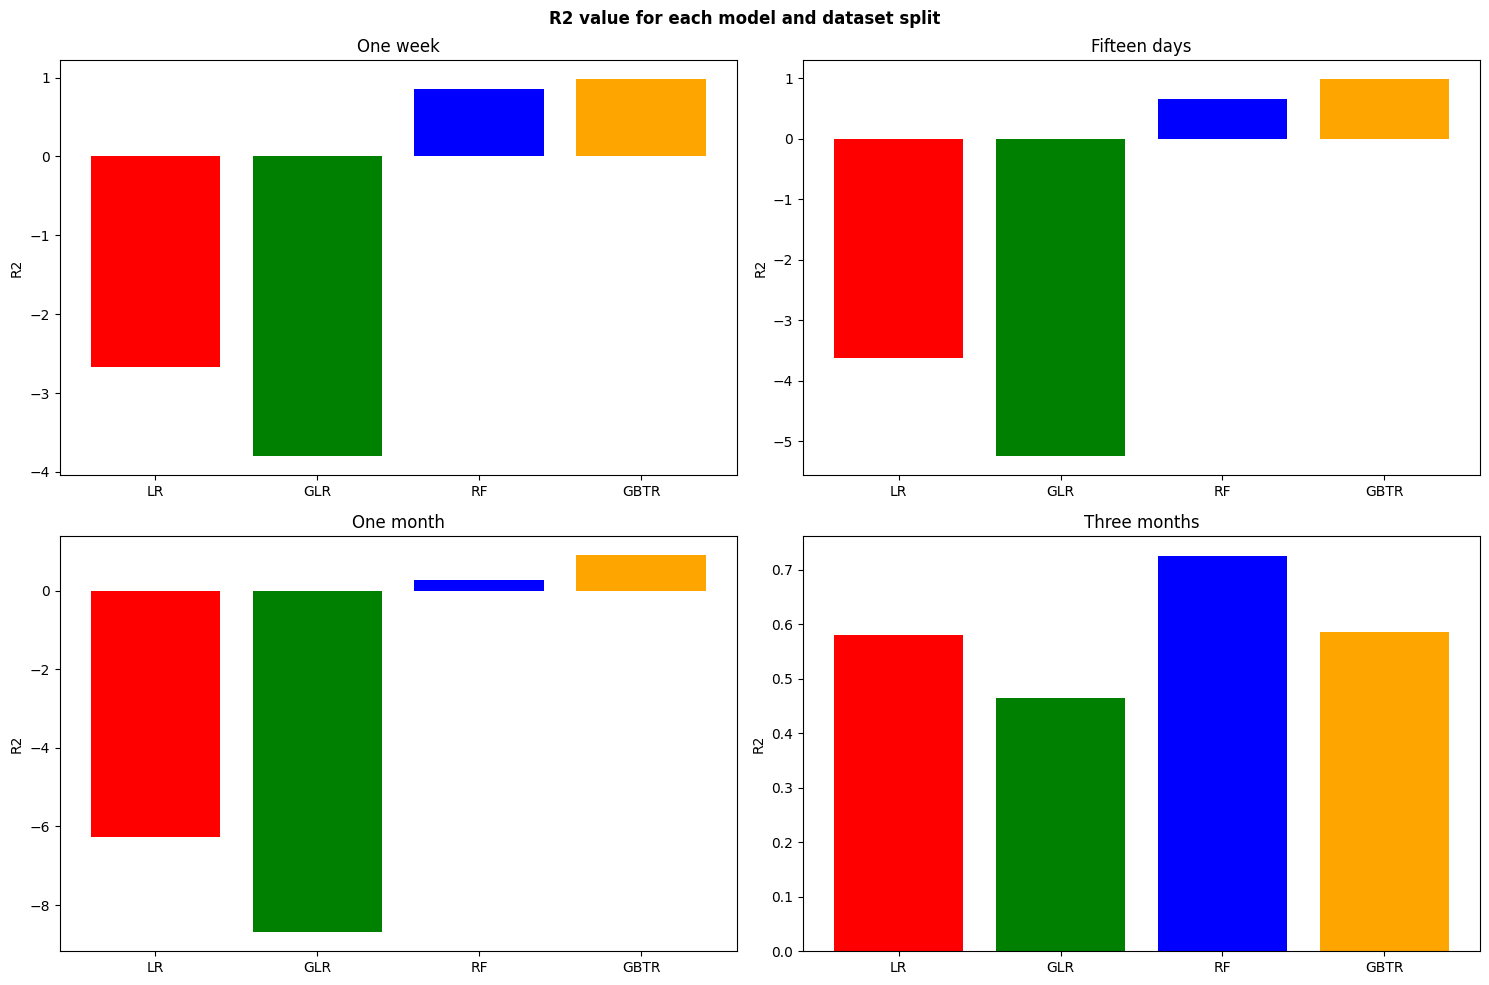

In [136]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, dataset in enumerate(datasets):
    ax = axs[i]
    data = merged_results_copy[merged_results_copy['Dataset'] == dataset]
    for j, model in enumerate(models):
        model_data = data[data['Model'] == model]
        ax.bar(j, model_data['R2'].values[0], color=colors[j])
    ax.set_title(dataset)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=0)
    ax.set_ylabel('R2')

fig.suptitle('R2 value for each model and dataset split', weight='bold')
plt.tight_layout()
plt.show()

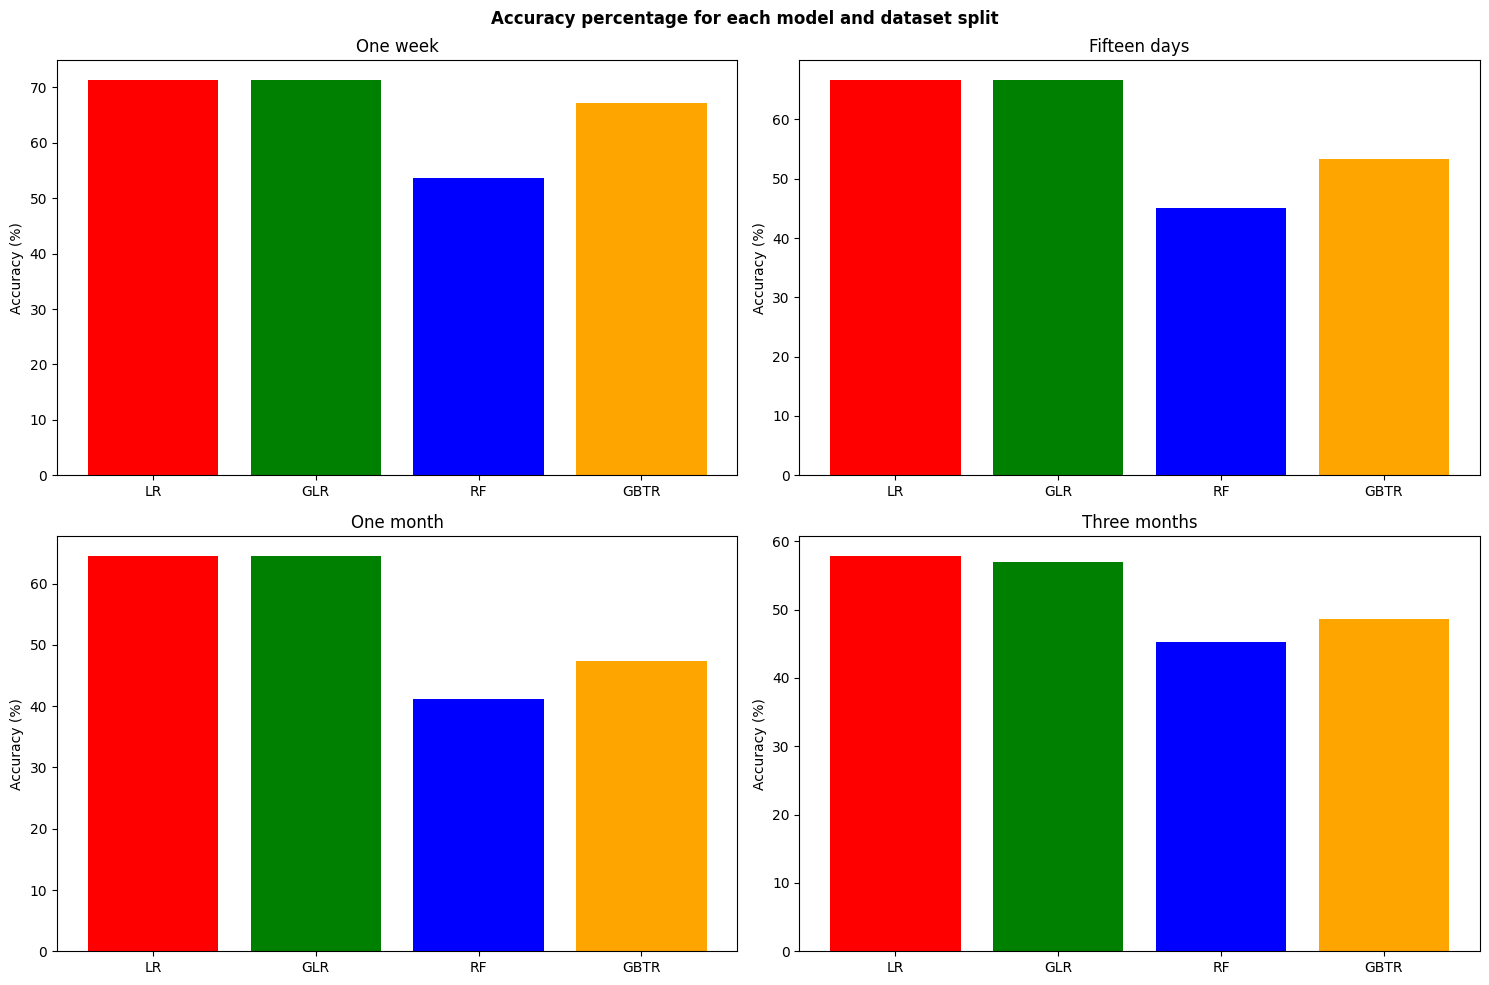

In [140]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, dataset in enumerate(datasets):
    ax = axs[i]
    data = merged_results_copy[merged_results_copy['Dataset'] == dataset]
    for j, model in enumerate(models):
        model_data = data[data['Model'] == model]
        ax.bar(j, model_data['Accuracy'].values[0], color=colors[j])
    ax.set_title(dataset)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=0)
    ax.set_ylabel('Accuracy (%)')

fig.suptitle('Accuracy percentage for each model and dataset split', weight='bold')
plt.tight_layout()
plt.show()

In [138]:
# Saving final test results
merged_results.to_csv(RESULTS_FINAL_DIR + "/final.csv", index=False)

In [ ]:
# Export notebook in html format (remember to save the notebook and change the model name)
if LOCAL_RUNNING:
    !jupyter nbconvert --to html 6-final-scores.ipynb --output 6-final-scores --output-dir='./exports'